
# Summative Exercise – Predictive Embeddings + RNN Classifier (Colab)

**Week 2 (NLP):** This summative task combines *predictive embeddings* (loaded from pre-trained **GloVe**, a Word2Vec-style model) with a compact **RNN** text classifier.

**You will:**
1. Load a small two-class dataset (20 Newsgroups subset).  
2. Tokenise and create padded sequences.  
3. Load pre-trained GloVe vectors and explore nearest neighbours.  
4. Build two models: (i) averaged-embedding baseline; (ii) SimpleRNN classifier using the same embeddings.  
5. Evaluate, compare, and reflect.

Note: You have complete all the missing parts in code to complete this exercise.
Missing parts are represented with '#########'.

*Estimated time: 90 minutes.*  


## Setup and versions

In [1]:

import os, random, sys, platform, numpy as np, tensorflow as tf, sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("Platform:", platform.platform())


Python: 3.10.19
TensorFlow: 2.20.0
NumPy: 1.26.4
scikit-learn: 1.5.1
Platform: macOS-15.6.1-arm64-arm-64bit



## 1. Load and prepare data

We use two categories to keep training fast. This mirrors the earlier classroom exercises.


In [2]:

import pandas as pd
cats = ['rec.autos', 'sci.electronics']
raw = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
df = pd.DataFrame({'text': raw.data, 'label': raw.target}).sample(n=1000, random_state=SEED).reset_index(drop=True)
df.head(3)


,text,label
0,# 74S\tLater modification of 74 for even highe...,1
1,\nrecently-manufactured locomotives have wheel...,0
2,"\nYes, Fred, my heart and prayers go out to th...",0



## 2. Tokenise and vectorise

We use Keras `Tokenizer` for simple, robust tokenisation. Then we create padded integer sequences.


In [3]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hint: try using 20000 words and maximum length of 120

num_words = 20000
# Least frequent words (not in 20k vocab) will be bucketed as <unk>
tokenizer = Tokenizer(num_words=num_words, oov_token="<unk>")
tokenizer.fit_on_texts(df["text"])

max_len = 120
# Convert texts to integer sequences (indices of the vocab) and pad them to the same length of 120 (adds 0s or cuts off, at 120, resp.), save that in X, label in y
# rare words get the <unk> index
seqs = tokenizer.texts_to_sequences(df["text"])
X = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")
y = df["label"].values  # labels

# word_index is the text vocabulary for ALL words (incl. rare words!) + <unk>
word_index = tokenizer.word_index
index_word = {i:w for w,i in word_index.items()}
vocab_size = min(num_words, len(word_index) + 1)
vocab_size
# vocab_size < num_words, so no <unk> needed!


12193

In [4]:
# Hint: 20% of data can go for testing
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train.shape, X_val.shape


((800, 120), (200, 120))


## 3. Load pre-trained predictive embeddings (GloVe)

We use **GloVe 6B** via Keras. If the download fails, you can continue with random initialisation.


In [5]:

import os, zipfile
from tensorflow.keras.utils import get_file
import numpy as np

EMBED_DIM = 100
# GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
# glove_zip_path = get_file("glove.6B.zip", GLOVE_URL, cache_dir=".", cache_subdir=".")
# if not os.path.exists("glove.6B.100d.txt"):
#     with zipfile.ZipFile(glove_zip_path, "r") as z:
#         z.extract("glove.6B.100d.txt", path=".")

# load GloVe embeddings into a dictionary
emb_index = {}
with open("data/glove.6B.100d.txt", "r", encoding="utf8") as f:
    for line in f:
        # parses the vector file line by line, the first part (part[0]) is the word, the rest (part[1:]) are the vector values
        parts = line.strip().split()
        word = parts[0]
        vec = np.array(parts[1:], dtype="float32")
        # store in dictionary word -> vector
        emb_index[word] = vec


# embedding matrix for our vocabulary
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, EMBED_DIM)).astype("float32")
hits = 0
# check all text words against GloVe embeddings
for word, idx in word_index.items():
    if idx >= vocab_size:
        continue # only look up top num_words frequent words (= after vocab_size, we have no indices, so could also break here?!)
    # Look up word in GloVe embeddings
    vec = emb_index.get(word)
    # if not found, just keep random vector 
    # (still distinct ones for all words unknown to GloVe, 
    # while rare words share the <unk> index and hence the same random vector)
    if vec is not None and vec.shape[0] == EMBED_DIM:
        embedding_matrix[idx] = vec
        hits += 1
print(f"Loaded embeddings: {len(emb_index)} | Vocab hits: {hits}/{vocab_size}")



Loaded embeddings: 400000 | Vocab hits: 10224/12193



## 4. Explore nearest neighbours (cosine similarity)


In [6]:

from numpy.linalg import norm

def nearest_neighbours(query, topk=10):
    q_index = word_index.get(query)
    if q_index is None:
        return []
    if q_index >= vocab_size:
        return nearest_neighbours("<unk>", topk=10)

    query_vector = embedding_matrix[q_index]

    sims = embedding_matrix @ query_vector / (norm(embedding_matrix, axis=1) * norm(query_vector) + 1e-8)
    idx = np.argsort(-sims)[:topk+1]
    return [(index_word[i], float(sims[i])) for i in idx if index_word[i] != query][:topk]
    
probes = ["doesntexist", "computerfest", "car", "engine", "battery", "circuit", "voltage"]
for p in probes:
    print(f"Probe: {p}")
    print(nearest_neighbours(p, topk=8))
    print("-"*50)


Probe: doesntexist
[]
--------------------------------------------------
Probe: computerfest
[('thermoelement', 0.37909552454948425), ('trails', 0.33428722620010376), ('fyi', 0.3287862241268158), ("exar's", 0.3279808461666107), ('exceptions', 0.3239617347717285), ('caveat', 0.3126457631587982), ('misconception', 0.3035734295845032), ('preserves', 0.298094242811203)]
--------------------------------------------------
Probe: car
[('vehicle', 0.8630838394165039), ('truck', 0.8597878217697144), ('cars', 0.837166965007782), ('driver', 0.8185909986495972), ('driving', 0.7812635898590088), ('vehicles', 0.7462256550788879), ('bus', 0.737270712852478), ('taxi', 0.7155268788337708)]
--------------------------------------------------
Probe: engine
[('engines', 0.8966865539550781), ('cylinder', 0.7133263945579529), ('powered', 0.7109490633010864), ('turbine', 0.6999304294586182), ('wheel', 0.6954973936080933), ('chassis', 0.6844566464424133), ('diesel', 0.680764377117157), ('v8', 0.656004369258880


## 5. Baseline: averaged embeddings + Logistic Regression


In [12]:

from sklearn.linear_model import LogisticRegression

# Hint: Iteration could be 300.

def doc_mean_vector(seq_row):
    # valid: list of embedding vectors for words in seq_row that are not padding (0) and within vocab_size
    valid = [embedding_matrix[idx] for idx in seq_row if idx != 0 and idx < vocab_size]
    if not valid:
        return np.zeros((EMBED_DIM,), dtype="float32")
    # return mean of valid vectors
    return np.mean(valid, axis=0)

X_tr_mean = np.stack([doc_mean_vector(r) for r in X_train])
X_va_mean = np.stack([doc_mean_vector(r) for r in X_val])

clf = LogisticRegression(max_iter=300)
clf.fit(X_tr_mean, y_train)
pred_lr = clf.predict(X_va_mean)

acc_lr = accuracy_score(y_val, pred_lr)
f1_lr = f1_score(y_val, pred_lr, average="macro")
print(f"Baseline (avg embeddings) | acc={acc_lr:.3f} | f1_macro={f1_lr:.3f}")
print(confusion_matrix(y_val, pred_lr))


Baseline (avg embeddings) | acc=0.870 | f1_macro=0.870
[[87 11]
 [15 87]]



## 6. RNN classifier with pre-trained embeddings (Keras)


In [8]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Hint: For dense layer use sigmoid as activation function. Use adam optimizer and loss should be binary crossentropy.

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=EMBED_DIM,
              input_length=X.shape[1], weights=[embedding_matrix],
              trainable=False),
    SimpleRNN(64, activation="tanh"),
    Dense(1, activation="sigmoid")
])

model.build(input_shape=(None, X.shape[1]))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


/Users/jus/Documents/Code/NLP_Uni/.venv10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 100)       │     1,219,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,229,925 (4.69 MB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 1,219,300 (4.65 MB)

In [9]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=32, verbose=1
)

y_pred_prob = model.predict(X_val, verbose=0).ravel()
y_pred = (y_pred_prob >= 0.5).astype("int64")

acc_rnn = accuracy_score(y_val, y_pred)
f1_rnn = f1_score(y_val, y_pred, average="macro")
print(f"RNN (frozen GloVe) | acc={acc_rnn:.3f} | f1_macro={f1_rnn:.3f}")


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4762 - loss: 0.7184 - val_accuracy: 0.5100 - val_loss: 0.7115
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5350 - loss: 0.6807 - val_accuracy: 0.5150 - val_loss: 0.7064
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5800 - loss: 0.6599 - val_accuracy: 0.5200 - val_loss: 0.7046
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5962 - loss: 0.6415 - val_accuracy: 0.5150 - val_loss: 0.7001
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6162 - loss: 0.6228 - val_accuracy: 0.5450 - val_loss: 0.6958
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6300 - loss: 0.6027 - val_accuracy: 0.5600 - val_loss: 0.6932
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6325 - loss: 0.5812 - val_accuracy: 0.5550 - val_loss: 0.6935
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6425 - loss: 0.5590 - val_accuracy: 0.5650 - val_loss

## 7. Compare results & confusion matrix

In [10]:

import pandas as pd
results = pd.DataFrame([
    {"model": "Avg-embeddings + LogisticRegression", "accuracy": acc_lr, "f1_macro": f1_lr},
    {"model": "SimpleRNN (frozen GloVe)", "accuracy": acc_rnn, "f1_macro": f1_rnn},
])
results


,model,accuracy,f1_macro
0,Avg-embeddings + LogisticRegression,0.87,0.870000
1,SimpleRNN (frozen GloVe),0.56,0.498575


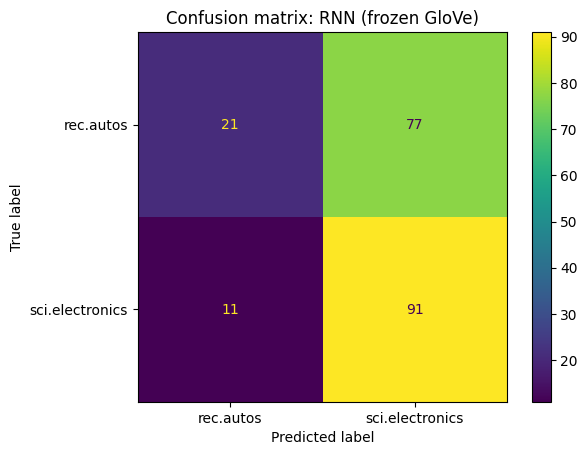

In [11]:

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rec.autos','sci.electronics'])
disp.plot(values_format='d')
plt.title("Confusion matrix: RNN (frozen GloVe)")
plt.show()



## 8. Reflection (120–180 words)

- Where did the averaged-embedding baseline do well, and where did the RNN improve?
- Why do predictive embeddings help compared with raw counts or TF-IDF?  
- If you fine-tuned the embedding layer (`trainable=True`) in this small-data setting, when would you expect gains or overfitting, and why?


The average-embedding baseline Linear Regression model did very much better than the RNN in both accuracy and f1 score. In fact, it mis-classified 75% of the rec.autos, while the Linear model had remarkeable good accuracy throughout. The RNN had less mis-classified sci.electronics examples. However, it seems that was more because it is biased much more towards sci.electronics, and not because it was better in separating. 

This behaviour is understandable as we are seeing a relatively small dataset, and maybe not enough trainingsdata for a RNN. On the other hand, averaging the vector embedding, and hence distilling a "meaning" for each example seems an intuitive fit for a Linear Regression model, as it should be able to calculate a best possiible hyperplane to separate between the two labels. 

Possibly an RNN may shine in larger sets with more complex labels. 

The advantage of the embeddings is that semantically related words are located near each other in the vector space, and averaging all tokens in an "autos" sequence will result in a point that is closer to other points with a lot of "auto" semantics (and similarly for "electronics"). This should separate these two vector categories naturally. 

With TF-IDF I could identify important words in a sequence, but there is no connection between words that may have a similar meaning, but are different surface forms. This makes it virtually impossible to classify with TF-IDF by topic, unless I use an intermediate step that assigns keywords to a subject domain (which would mean keeping some sort of table of keywords). 

If I set trainable=True, as the dataset is small, I think it could overfit. As an RNN learns from the sequence of tokens, you would need many tokens in very different sequence scenarios in order to really improve the embeddings, and 1,000 sequences of max. 120 tokens (max. 120,000 tokens with a vocabulary of 12,193) are not enough by far. 


